<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [1247]:
#@title Current Date
Today = '2021-08-22' #@param {type:"date"}


In [1248]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20214537" #@param {type:"string"}
Student_full_name = "Tom Keane" #@param {type:"string"}
#@markdown ---

In [1249]:
#@title Notebook information
Notebook_type = 'Example' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [1250]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [1251]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [1252]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [1253]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Training & Test Data

In [1254]:
def import_datasets(git_link = 'https://raw.githubusercontent.com/tomkeane07/AI-Projects-UL/main/semester3/MachineLearningApplications/PiecewiseRegression'):
  return {
      'house_test' : pd.read_csv(git_link+'/house_test.csv'),
      'house_train' : pd.read_csv(git_link+'/house_train.csv'),
      'true_price'  : pd.read_csv(git_link+'/true_price.csv')}

# try:
#   dbs
# except:
#   dbs = import_datasets()
dbs = import_datasets()


# split data into training and test
from sklearn.model_selection import train_test_split

# training: 70% (0.7), test: 30% (0.3) 
# you could try any other combination 
# but consider 50% of training as the low boundary
# X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

### Train dataset

In [1255]:
dftrain = dbs['house_test' ]
dftest =  dbs['house_train']
dfcost = dbs['true_price']
df = dftrain.append(dftest)

In [1256]:
# show first data frame rows 
dftrain.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface
0,12373510,Skerries,2.0,4.0,G,Dublin,"It's all in the name ""Island View"";. Truly won...",prod,"Parking,Alarm,Oil Fired Central Heating",Breath-taking panoramic views radiate from thi...,53.566881,-6.101148,NaN,sale,bungalow,142.0
1,12422623,Lucan,2.0,3.0,C1,Dublin,REA McDonald - Lucan' s longest established es...,prod,NaN,Gas fired central heating.\nDouble glazed wind...,53.362992,-6.452909,NaN,sale,terraced,114.0
2,12377408,Swords,3.0,4.0,B3,Dublin,REA Grimes are proud to present to the market ...,prod,NaN,Pristine condition throughout\nHighly sought-a...,53.454198,-6.262964,NaN,sale,semi-detached,172.0
3,12420093,Lucan,4.0,3.0,A3,Dublin,"REA McDonald, Lucan' s longest established est...",prod,NaN,A-rated home within a short walk of Lucan Vill...,53.354402,-6.458647,NaN,sale,semi-detached,132.4
4,12417338,Clondalkin,1.0,3.0,E2,Dublin,"Hibernian Auctioneers are delighted to bring, ...",prod,"Parking,Gas Fired Central Heating,Wired for Ca...",Mature Location \nGas Heating \nClose to Ameni...,53.336530,-6.393587,NaN,sale,semi-detached,88.0


In [1257]:
print("missing values _ %")
print(df.isna().sum()* 100 / len(df))
print("_________\nunique values")
print(df.nunique(axis=0))

missing values _ %
ad_id                  0.000000
area                   0.000000
bathrooms              1.464675
beds                   1.464675
ber_classification    21.051120
county                 0.000000
description_block      0.000000
environment            0.000000
facility              66.858128
features               0.000000
latitude               0.000000
longitude              0.000000
no_of_units           98.305572
property_category      0.000000
property_type          1.464675
surface               15.824239
price                 16.944285
dtype: float64
_________
unique values
ad_id                 3482
area                   157
bathrooms               13
beds                    15
ber_classification      16
county                   1
description_block     3476
environment              1
facility                35
features              2378
latitude              3353
longitude             3361
no_of_units             22
property_category        2
property_type       

**no_of_units** can go as there is too little data there.

 **county**, **environment**  can also go as there's only one value for each.
 
 **area** will also have to go as it has too many values to encode

facility has a lot of missing values. Though this field being missing may be valid data anyway.

One-hot encoding and simple imputation can be applied to the other categories with missing values less than 25 %



In [1258]:
dropcols = ['no_of_units', 'county', 'environment', 'area', 'description_block']

In [1259]:
print("\n\ndescription_block")
print(list(df.head(3)['description_block']))
print("\n\nfacility")
print(list(df.head(3)['facility']))
print("\n\nfeatures")
print(list(df.head(3)['features']))



description_block
['It\'s all in the name "Island View";. Truly wonderful waterside residence set on approx. 0.66 of an acre of mature gardens, with magnificent uninterrupted sea and coastal views over Skerries Bay and Islands. The internal arrangement which extends to approx. 1,500sq ft has been designed to take full advantage of its coastal setting with the Kitchen diner having access to an extended terrace to the side and rear, enjoying panoramic sea views.\n\nFeatures - \nBreath-taking panoramic views radiate from this waterside property\nDetached 4 bed bungalow with attic conversion, on c.0.66 acre elevated site\nLarge kitchen Diner to rear benefiting from stunning island views\nLarge storage shed to rear with detached wooden cabin\nSunroom off Kitchen diner overlooking coast\nLarge decking to side and rear \nShort walk of the beach and Skerries Golf and Rugby clubs\nNeighbourhood shopping is available within a two minute walk on Shenick road\n\nEntrance porch    With wooden flo

Having looked at the '**features**, I have surmised that each feature is marked by a '\n' new line. Similarly **facilities** are listed and separated by commas - ','.
**description_block** has too much text to treat the same way

In [1260]:
print("\ntrain")
display(dftrain.describe())
print("\ntest")
display(dftest.describe())
print("\ncost")
display(dfcost.describe())


train


,ad_id,bathrooms,beds,latitude,longitude,no_of_units,surface
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,0.0,500.000000
mean,1.231695e+07,1.994000,2.930000,53.356034,-6.247842,NaN,156.007671
std,1.485832e+05,1.106532,1.191612,0.081905,0.088552,NaN,344.497362
min,1.130615e+07,0.000000,0.000000,53.221348,-6.496987,NaN,33.500000
25%,1.228617e+07,1.000000,2.000000,53.297373,-6.296404,NaN,72.375000
50%,1.237964e+07,2.000000,3.000000,53.339547,-6.243572,NaN,98.000000
75%,1.240544e+07,3.000000,4.000000,53.381650,-6.185055,NaN,138.935000
max,1.242809e+07,8.000000,7.000000,53.619775,-6.064874,NaN,5746.536120



test


,ad_id,bathrooms,beds,latitude,longitude,no_of_units,price,surface
count,2.982000e+03,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2.892000e+03,2431.000000
mean,1.224065e+07,1.998635,2.979188,53.355991,-6.257175,7.440678,5.323536e+05,318.851787
std,5.793037e+05,1.291875,1.468408,0.086748,0.141906,8.937081,5.678148e+05,4389.423136
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,0.000000,1.999500e+04,3.400000
25%,1.226813e+07,1.000000,2.000000,53.298929,-6.314064,2.000000,2.800000e+05,74.100000
50%,1.237758e+07,2.000000,3.000000,53.345497,-6.252254,3.000000,3.800000e+05,100.000000
75%,1.240294e+07,3.000000,4.000000,53.388845,-6.196049,8.000000,5.750000e+05,142.000000
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,36.000000,9.995000e+06,182108.539008



cost


,Id,Expected
count,5.000000e+02,5.000000e+02
mean,1.231695e+07,5.810356e+05
std,1.485832e+05,6.009194e+05
min,1.130615e+07,8.500000e+04
25%,1.228617e+07,2.950000e+05
50%,1.237964e+07,4.250000e+05
75%,1.240544e+07,5.950000e+05
max,1.242809e+07,5.750000e+06


### Expected Cost dataset

### Data Encoding

In [1261]:
def col_to_colCount(df, col, divider):
  #this is designed for features and facilities to convert it to a rough count
  # of features, based on how they're typically listed in the df
  df[col] = df[col].fillna("")
  df[col] = df[col].apply(lambda x: x.count(divider)+1)
  return df

ber_classification_mapper = {
    #Thanks Nigel Portley
    "SINo666of2006exempt": 1,
    "A1": 2,
    "A2": 3,
    "A3": 4,
    "B1": 5,
    "B2": 6,
    "B3": 7,
    "C1": 8,
    "C2": 9,
    "C3": 10,
    "D1": 11,
    "D2": 12,
    "E1": 13,
    "E2": 14,
    "F": 15,
    "G": 16
}

property_type_mapper = {
      #Thanks Nigel Portley
    "apartment": 1,
    "bungalow": 5,
    "detached": 9,
    "duplex": 2,
    "end-of-terrace": 6,
    "semi-detached": 8,
    "site": 3,
    "studio": 0,
    "terraced": 4,
    "townhouse": 7
}

def drop_cols(df, dropcols):
  for col in dropcols:
    df.drop(col, axis=1, inplace=True)
  return df

def onehotencode(df, col, drop_first=True):
  return pd.get_dummies(df, columns=[col], 
                        dummy_na=True, 
                        drop_first=drop_first)

def encode(df, dropcols = []):
  df = col_to_colCount(df, 'features' ,'\n')
  df = col_to_colCount(df, 'facility' ,',')
  df['ber_classification'] = df['ber_classification'].replace(ber_classification_mapper)
  df['ber_classification'].fillna(df['ber_classification'].mean(), inplace=True)

  df['property_type'] = df['property_type'].replace(property_type_mapper)
  df['property_type'].fillna(df['property_type'].mean(), inplace=True)

  df = onehotencode(df, 'property_category', True)
  df['surface'].fillna(df['surface'].median(), inplace=True)
  df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
  df['beds'].fillna(df['beds'].median(), inplace=True)
  df = drop_cols(df, dropcols)
  return df

In [1262]:
dftrain, dftest= encode(dftrain, dropcols), encode(dftest, dropcols)
df = dftrain.append(dftest)

In [1263]:
display(df.describe())
display(df.head())
print(df.isna().sum())

,ad_id,bathrooms,beds,ber_classification,facility,features,latitude,longitude,property_type,surface,property_category_nan,price,property_category_sale
count,3.482000e+03,3482.000000,3482.000000,3482.000000,3482.000000,3482.000000,3482.000000,3482.000000,3482.000000,3482.000000,3482.0,2.892000e+03,2982.000000
mean,1.225161e+07,1.997990,2.972430,10.690866,1.490810,5.920448,53.355998,-6.255835,5.085109,260.836453,0.0,5.323536e+05,0.980215
std,5.396944e+05,1.257095,1.420836,2.902159,0.925276,3.802393,0.086058,0.135572,3.020620,3670.814218,0.0,5.678148e+05,0.139285
min,9.968870e+05,0.000000,0.000000,1.000000,1.000000,1.000000,51.458439,-6.521183,0.000000,3.400000,0.0,1.999500e+04,0.000000
25%,1.226969e+07,1.000000,2.000000,9.000000,1.000000,1.000000,53.298454,-6.311559,1.000000,78.000000,0.0,2.800000e+05,1.000000
50%,1.237778e+07,2.000000,3.000000,10.688503,1.000000,7.000000,53.344409,-6.250564,5.000000,100.000000,0.0,3.800000e+05,1.000000
75%,1.240319e+07,3.000000,4.000000,12.000000,2.000000,9.000000,53.388415,-6.193062,8.000000,130.000000,0.0,5.750000e+05,1.000000
max,1.242836e+07,18.000000,27.000000,16.000000,5.000000,11.000000,53.630588,-1.744995,9.000000,182108.539008,0.0,9.995000e+06,1.000000


,ad_id,bathrooms,beds,ber_classification,facility,features,latitude,longitude,property_type,surface,property_category_nan,price,property_category_sale
0,12373510,2.0,4.0,16.0,3,4,53.566881,-6.101148,5.0,142.0,0,NaN,NaN
1,12422623,2.0,3.0,8.0,1,7,53.362992,-6.452909,4.0,114.0,0,NaN,NaN
2,12377408,3.0,4.0,7.0,1,11,53.454198,-6.262964,8.0,172.0,0,NaN,NaN
3,12420093,4.0,3.0,4.0,1,9,53.354402,-6.458647,8.0,132.4,0,NaN,NaN
4,12417338,1.0,3.0,14.0,3,8,53.336530,-6.393587,8.0,88.0,0,NaN,NaN


ad_id                       0
bathrooms                   0
beds                        0
ber_classification          0
facility                    0
features                    0
latitude                    0
longitude                   0
property_type               0
surface                     0
property_category_nan       0
price                     590
property_category_sale    500
dtype: int64


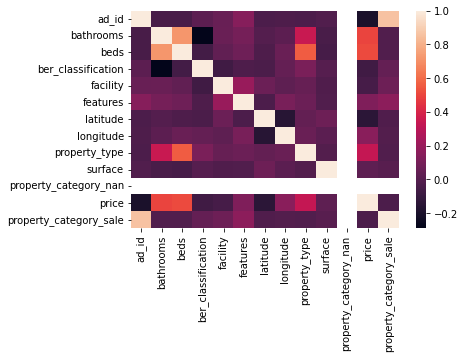

In [1264]:
sns.heatmap(df.corr())

In [1265]:
# can drop property category


# PIECEWISE REGRESSION

## Full Model

In [1266]:
print('Number of nan in df_subset_train dataset: ',dftrain.isnull().sum().sum())
print('Number of nan in df_subset_test dataset: ',dftest.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  90


In [1267]:
# train set, input columns
Xs_train = dftrain.iloc[:,0:-1].values 
# train set, output column, cost
ys_train = dftrain.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = dftest.iloc[:,0:].values 
# test set, output column, cost
y_test = dfcost.Expected.values

In [1268]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

ValueError: ignored

In [ ]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

featrain = ['latitude', 'longitude', 'bathrooms', 'beds', 'surface']
# dropna: remove missing values
df_subset_train = dftrain[featrain].dropna(axis=0)

featest = featrain
df_subset_test  =  dftest[featest].dropna(axis=0)

# cost
df_cost = df_cost[df_cost.index.isin(df_subset_test.index)]

In [ ]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

In [ ]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

## Clustering

### Full Model

In [ ]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)


### Clusters

In [ ]:
# train clusters



In [ ]:
# test clusters


## Piecewise Model

In [ ]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])



##Simulations

### Only Cluster 0

## Overall

## Test set performance

### PPC on the Test set



# SUMMARY